# Introduction

In this notebook we visualize both the trainings statistics and the performance of the trained models for the lunar lander agent trained via i) the actor-critic algorithm and ii) deep Q-learning


In [1]:
import matplotlib.pyplot as plt
import glob
import numpy as np
import h5py
import copy
import itertools
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    'font.size': 25,
    "font.sans-serif": "computer modern",
})

# for creating videos of the best models:
import torch
from gymnasium.wrappers.monitoring import video_recorder
import gymnasium as gym
#
# to load the agent class, we add the directory where it is located to the
# python path of this notebook:
agent_dir = '../'
import sys
sys.path.append(agent_dir)
import agent_class as agent


# Load training- and simulation data

In [2]:
files = glob.glob('./data/agent_*_training_data.h5')

algorithms = {0:'actor-critic',
            1:'dqn',
            }

template_dict = {value:{} for value in algorithms.values()}
template_dict_counts = {value:0 for value in algorithms.values()}

files_parameters = copy.deepcopy(template_dict)
files_training = copy.deepcopy(template_dict)
files_execution_time = copy.deepcopy(template_dict)
files_trajectories = copy.deepcopy(template_dict)

counts = copy.deepcopy(template_dict_counts)
failed = copy.deepcopy(template_dict_counts)

training_n_episodes = copy.deepcopy(template_dict)
training_n_epochs = copy.deepcopy(template_dict)
training_n_steps_simulated = copy.deepcopy(template_dict)
#
training_episode_durations = copy.deepcopy(template_dict)
training_episode_returns = copy.deepcopy(template_dict)
training_execution_time = copy.deepcopy(template_dict)

#
traj_return_per_episode = copy.deepcopy(template_dict)
traj_duration_per_episode = copy.deepcopy(template_dict)

mean_return_per_episode = copy.deepcopy(template_dict)
mean_duration_per_episode = copy.deepcopy(template_dict)

worst_mean = {value:np.inf for value in algorithms.values()}
best_mean = {value:-np.inf for value in algorithms.values()}
worst_model = {value:0 for value in algorithms.values()}
best_model = {value:0 for value in algorithms.values()}



def fn_training_to_trajectories(filename):
    return filename.replace('training_data','trajs').replace('h5','tar')

def fn_training_to_parameters(filename):
    return filename.replace('_training_data','').replace('h5','tar')

def fn_training_to_execution_time(filename):
    return filename.replace('training_data.h5','execution_time.txt')

def fn_trajectories_to_training(filename):
    return filename.replace('trajs','training_data')

for i, file in enumerate(files):
    #
    if 'dqn' in file:
        algorithm = 'dqn'
    else:
        algorithm = 'actor-critic'
    #
    with h5py.File(file, 'r') as hf:
        current_return_per_episode = np.array(hf['epsiode_returns'][()] )
        if len(current_return_per_episode) == 10000:
            print('training failed for {0}'.format(file))
            failed[algorithm] += 1
            continue
        else:
            c = counts[algorithm]
            files_training[algorithm][c] = file
            files_execution_time[algorithm][c] = fn_training_to_execution_time(file)
            files_trajectories[algorithm][c] = fn_training_to_trajectories(file)
            files_parameters[algorithm][c] = fn_training_to_parameters(file)
            #
            training_epochs = np.array(hf['n_training_epochs'][()] )
            training_n_epochs[algorithm][c] = training_epochs[-1]
            #
            n_episodes_ = len(hf['episode_durations'][()] )
            training_n_episodes[algorithm][c] = n_episodes_
            #
            n_steps_simulated_ = np.array(hf['n_steps_simulated'][()] )
            training_n_steps_simulated[algorithm][c] = n_steps_simulated_[-1]
            #
            training_episode_durations[algorithm][c] = np.array(hf['episode_durations'][()] )
            training_episode_returns[algorithm][c] = current_return_per_episode
            #
            counts[algorithm] += 1
    #
    training_execution_time[algorithm][c] = \
                        np.loadtxt(files_execution_time[algorithm][c])
    #
    with h5py.File(files_trajectories[algorithm][c], 'r') as hf:
        #
        current_return_per_episode = np.array(hf['returns'][()] )
        traj_return_per_episode[algorithm][c] = current_return_per_episode
        #
        current_duration_per_episode = np.array( hf['durations'][()] )
        traj_duration_per_episode[algorithm][c] = current_duration_per_episode
        #
        current_mean_return_per_episode = np.mean(current_return_per_episode)
        mean_return_per_episode[algorithm][c] = current_mean_return_per_episode
        if current_mean_return_per_episode < worst_mean[algorithm]:
            worst_model[algorithm] = c
            worst_mean[algorithm] = current_mean_return_per_episode
        if current_mean_return_per_episode > best_mean[algorithm]:
            best_model[algorithm] = c
            best_mean[algorithm] = current_mean_return_per_episode
        #
        current_mean_duration_per_episode = np.mean(current_duration_per_episode)
        mean_duration_per_episode[algorithm][c] = current_mean_duration_per_episode

output_string = ("For algorithm {0}, we observe {1} failed trainings "
             "out of {2} trainings in total. This is a failure rate of "
             "{3:<3.1f}%")
for current_algorithm in algorithms.values():
    current_failed = failed[current_algorithm]
    current_count = counts[current_algorithm]
    print(output_string.format(current_algorithm,current_failed,current_count,
         current_failed/(current_failed+current_count)*100))


For algorithm actor-critic, we observe 0 failed trainings out of 500 trainings in total. This is a failure rate of 0.0%
For algorithm dqn, we observe 0 failed trainings out of 500 trainings in total. This is a failure rate of 0.0%


# Plot number of episodes needed for training

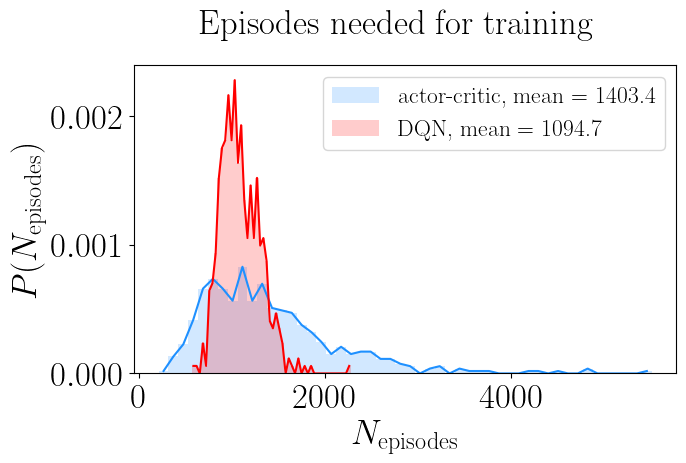

In [3]:
colors = {'actor-critic':'dodgerblue',
                'dqn':'red'}

def plot_training_stats(save=False):
        # 
        fig,ax = plt.subplots(1,1,figsize=(7,4))
        fig.suptitle('Episodes needed for training',
                        y=1.02,fontsize=25)
        #
        mean_values = {}
        #
        for algorithm in algorithms.values():
                current_array = np.array( list(training_n_episodes[algorithm].values()))

                hist, bin_edges = np.histogram(current_array,density=True,
                                                bins=50)
                bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
                bin_width = bin_edges[1] - bin_edges[0]
                
                #
                mean_values[algorithm] =  np.mean(current_array)
                #
                if algorithm == 'dqn':
                        label=algorithm.upper()
                else:
                        label = algorithm
                #
                ax.bar(bin_centers,hist,width=bin_width,
                        alpha=0.2,
                        label='{0}, mean = {1:3.1f}'.format(label,
                                              mean_values[algorithm] ),
                        color=colors[algorithm])
                
                if True:
                        ax.plot(bin_centers, hist,
                                        color=colors[algorithm])
                #
                

        ax.set_xlabel(r'$N_{\mathrm{episodes}}$')
        ax.set_ylabel(r'$P(N_{\mathrm{episodes}})$')

        ax.legend(loc='best',fontsize=17)

        plt.show()
        if save:
                fig.savefig('training_n_episodes.pdf',bbox_inches='tight')
                fig.savefig('training_n_episodes.png',bbox_inches='tight',
                                dpi=300)
        plt.close(fig)
        #
        return mean_values

mean_training_episodes = plot_training_stats(save=True)

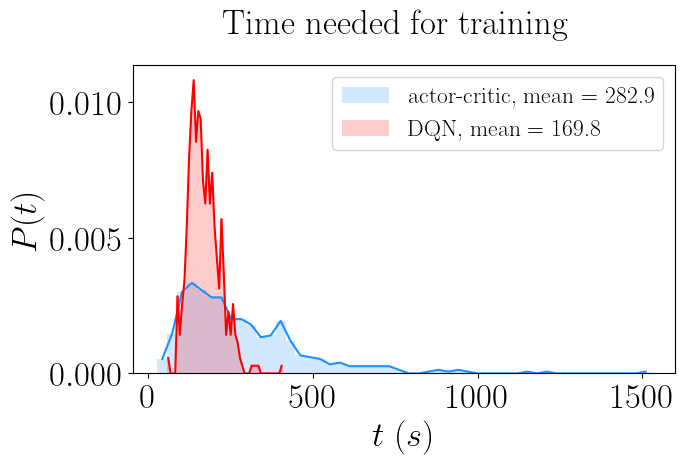

In [4]:
def plot_execution_time(save=False):
        # 
        fig,ax = plt.subplots(1,1,figsize=(7,4))
        fig.suptitle('Time needed for training',
                        y=1.02,fontsize=25)
        #
        mean_training_times = {}
        #
        for algorithm in algorithms.values():
                current_array = np.array( list(training_execution_time[algorithm].values()))

                hist, bin_edges = np.histogram(current_array,density=True,
                                                bins=50)
                bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
                bin_width = bin_edges[1] - bin_edges[0]
                
                mean_training_times[algorithm] = np.mean(current_array)
                #
                if algorithm == 'dqn':
                        label=algorithm.upper()
                else:
                        label = algorithm
                #
                ax.bar(bin_centers,hist,width=bin_width,
                        alpha=0.2,
                        label='{0}, mean = {1:3.1f}'.format(label,
                                               mean_training_times[algorithm]),
                        color=colors[algorithm])
                
                if True:
                        ax.plot(bin_centers, hist,
                                        color=colors[algorithm])

        ax.set_xlabel(r'$t$ ($s$)')
        ax.set_ylabel(r'$P(t)$')

        ax.legend(loc='best',fontsize=17)

        plt.show()
        if save:
                fig.savefig('training_execution_time.pdf',bbox_inches='tight')
                fig.savefig('training_execution_time.png',bbox_inches='tight',
                                dpi=300)
        plt.close(fig)
        #
        return mean_training_times
        #
mean_training_times = plot_execution_time(save=True)

In [5]:
def get_ratio(dictionary_values):
    for i, algorithm in algorithms.items():
        #
        if i == 0:
            x = dictionary_values[algorithm]
        else:
            x /= dictionary_values[algorithm]
    return x

print('Ratio for mean number of training episodes:')
print('(# training episodes for {0})/(# training episodes for {1})'.format(
        algorithms[0],algorithms[1]),end='')
print(' = {0:3.2f}'.format(get_ratio(mean_training_episodes)))

print('Ratio for mean time needed for training:')
print('(# training time for {0})/(# training time for {1})'.format(
        algorithms[0],algorithms[1]),end='')
print(' = {0:3.2f}'.format(get_ratio(mean_training_times)))

Ratio for mean number of training episodes:
(# training episodes for actor-critic)/(# training episodes for dqn) = 1.28
Ratio for mean time needed for training:
(# training time for actor-critic)/(# training time for dqn) = 1.67


# Return distribution for trained models

actor-critic, full mean = 211.61
actor-critic, P(return < -200) = 1.36%
actor-critic, minimal observed reward = -9086.224
dqn, full mean = 227.40
dqn, P(return < -200) = 0.20%
dqn, minimal observed reward = -2143.187


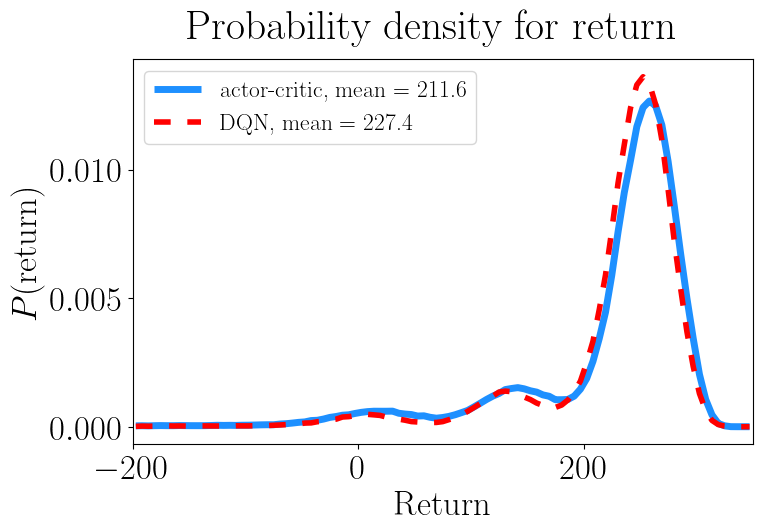

actor-critic, full mean = 261.95
actor-critic, P(return < -200) = 0.40%
actor-critic, minimal observed reward = -304.133
dqn, full mean = 237.99
dqn, P(return < -200) = 0.00%
dqn, minimal observed reward = 10.730


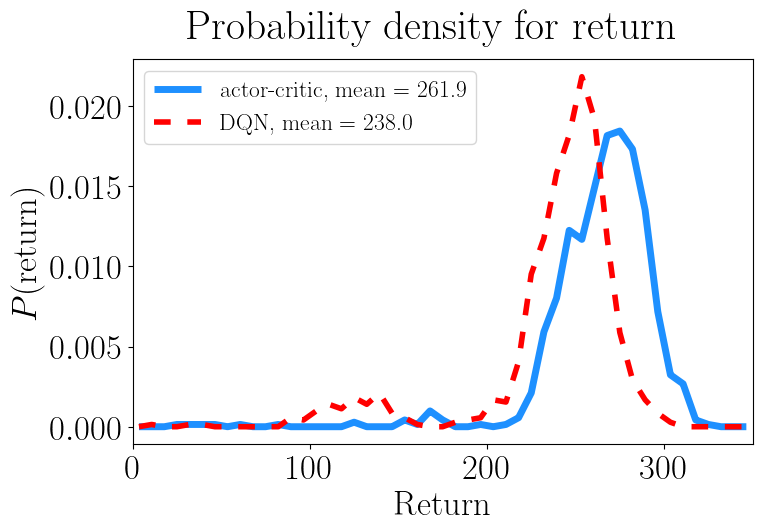

In [6]:
dashes = {'actor-critic':[1,0],
                'dqn':[3,3]
                }
linewidths = {'actor-critic':5,
                'dqn':4
                }

best_models = {value:0 for value in algorithms.values()}

def plot_returns(best_performing=False,save=False):
        # 
        fig,ax = plt.subplots(1,1,figsize=(8,5))
        #
        for algorithm in algorithms.values():
                if best_performing:
                        best_mean = -np.inf
                        for i, current_returns in traj_return_per_episode[algorithm].items():
                                current_mean = np.mean(current_returns)
                                if current_mean > best_mean:
                                        i_best = i
                                        mean_best = current_mean.copy()
                        best_models[algorithm] = i_best
                        current_array = traj_return_per_episode[algorithm][i_best]
                        #
                        xlims = [0,350]
                        filename = 'return_distribution_best'
                        N_bin_edges = 50
                else:
                        current_array = np.array( list(traj_return_per_episode[algorithm].values()))
                        xlims = [-200,350]
                        filename = 'return_distribution'
                        N_bin_edges = 100
                #
                current_mean = np.mean(current_array)
                print('{0}, full mean = {1:3.2f}'.format(algorithm,current_mean))
                cutoff = -200
                mask = (current_array < cutoff)
                print('{0}, P(return < {1}) = {2:3.2f}%'.format(algorithm,cutoff,
                        np.sum(mask)/np.prod(np.shape(mask))*100))
                print('{0}, minimal observed reward = {1:3.3f}'.format(algorithm,
                                np.min(current_array)))
                #current_array = current_array[~mask]
                #print(algorithm,'mean =',np.mean(current_array))

                #
                if algorithm == 'dqn':
                        label=algorithm.upper()
                else:
                        label = algorithm
                #
                bin_edges = np.linspace(*xlims,num=N_bin_edges)
                hist, bin_edges = np.histogram(current_array,density=True,
                                                bins=bin_edges)
                bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
                ax.plot(bin_centers,hist,
                       lw=linewidths[algorithm],
                       dashes=dashes[algorithm],
                        label='{0}, mean = {1:3.1f}'.format(label,
                                                np.mean(current_array)),
                        color=colors[algorithm])

        ax.set_xlabel(r'Return')
        ax.set_ylabel(r'$P$(return)')
        fig.suptitle(r'Probability density for return')
        ax.set_xlim(*xlims)

        ax.legend(loc='best',fontsize=17)

        plt.show()
        if save:
                fig.savefig('{0}.pdf'.format(filename),bbox_inches='tight')
                fig.savefig('{0}.png'.format(filename),bbox_inches='tight',
                                dpi=300)
        plt.close(fig)
        #
plot_returns(save=True)
plot_returns(best_performing=True,save=True)

# Videos of best-performing models

In [7]:
# https://github.com/openai/gym/issues/2433
# Wrapper class that calls the "event loop" for us when rendering.
class PyGameWrapper(gym.Wrapper):
    def render(self, **kwargs):
        retval = self.env.render( **kwargs)
        for event in pygame.event.get():
            pass
        return retval


def create_video(filename_model,episode=-1,N_runs=10,
                filename='video'):
    #
    # load model
    input_dictionary = torch.load(open(filename_model,'rb'))
    dict_keys = list(input_dictionary.keys())
    if episode == -1:
        dictionary_key = dict_keys[-1]
    else:
        dictionary_key = episode
    #
    input_dictionary_ = input_dictionary[dictionary_key]
    #
    N_state = 8
    N_actions = 4
    parameters = {'N_state':N_state,
             'N_actions':N_actions}
    if 'dqn' in filename_model:
        my_agent = agent.dqn(parameters=parameters)
    else:
        my_agent = agent.actor_critic(parameters=parameters)
    my_agent.load_state(state=input_dictionary_)
    #
    env = gym.make('LunarLander-v2', render_mode="rgb_array")
    video = video_recorder.VideoRecorder(env, './{0}.mp4'.format(filename))
    for j in range(N_runs):
        state, info = env.reset()

        total_reward = 0
        for i in itertools.count():
            #env.render()
            video.capture_frame()

            action = my_agent.act(state)
            state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_reward += reward

            if done:
                break

        print(i,total_reward)
    video.close()
    env.close()

for algorithm, index in best_models.items():
    print("Creating video for algorithm {0}".format(algorithm))
    filename_model = files_parameters[algorithm][index]
    filename_video = 'video_{0}'.format(algorithm.replace(',','').replace(
                                ' ','_'))
    create_video(filename_model=filename_model,
                    filename=filename_video)

Creating video for algorithm actor-critic
252 227.70442238494596
248 292.3459146862508
254 265.7270329544778
270 285.8125873312322
263 257.5671350176782
244 284.7803039250821
270 280.41032231890165
248 253.08514271727984
253 231.7203564620938
269 214.75213597940322
Moviepy - Building video ./video_actor-critic.mp4.
Moviepy - Writing video ./video_actor-critic.mp4



Moviepy - Done !
Moviepy - video ready ./video_actor-critic.mp4
Creating video for algorithm dqn
389 270.01162832191255
360 249.2516790554995
332 265.2605602622203
305 256.9411832401398
354 212.96286602384015
999 133.25230829341905
314 246.97197130896933
351 268.68716777769157
287 264.96512028219865
315 234.45242490109592
Moviepy - Building video ./video_dqn.mp4.
Moviepy - Writing video ./video_dqn.mp4



Moviepy - Done !
Moviepy - video ready ./video_dqn.mp4
